In [397]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import DBSCAN

%matplotlib inline

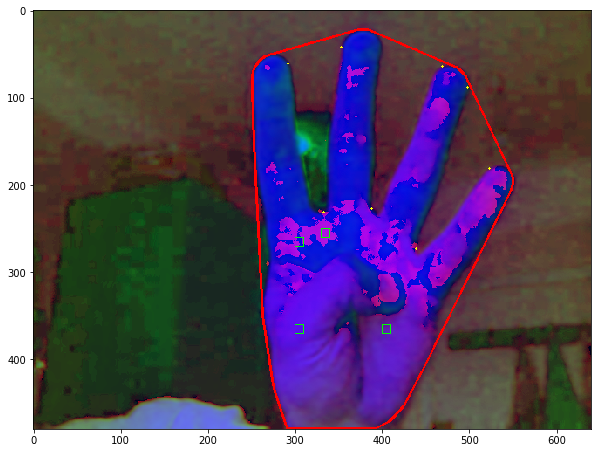

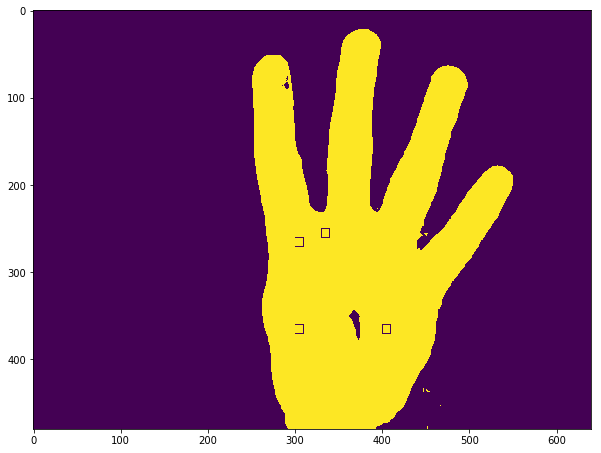

CPU times: user 1.87 s, sys: 322 ms, total: 2.19 s
Wall time: 2.88 s


In [899]:
%%time

image = './memage2.jpg'
kernel = np.ones((3,3),np.uint8)
image = cv2.imread(image)
image2 = image.copy()

image = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

frame3 = image[330:340,250:260]
cv2.rectangle(image,(330,250),(340,260),(0,255,0))
frame4 = image[300:310,260:270]
cv2.rectangle(image,(300 ,260), (310, 270),(0,255,0))
frame5 = image[300:310,360:370]
cv2.rectangle(image,(300 ,360), (310, 370),(0,255,0))
frame6 = image[400:410,360:370]
cv2.rectangle(image,(400 ,360), (410, 370),(0,255,0))
# hsv ranges for hand skin
lower_skin = np.array([0,0,80], dtype=np.uint8)
upper_skin = np.array([255,80,255], dtype=np.uint8)
mask = cv2.inRange(image, lower_skin, upper_skin)

leftmost = max_hull[max_hull[:,:,0].argmin()][0]
rightmost = max_hull[max_hull[:,:,0].argmax()][0]
delta = np.linalg.norm(leftmost-rightmost) // 8


contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

max_contour = max(contours,key=lambda x: cv2.contourArea(x))
cnt = contours[0] # delete excess dim for list
max_hull = cv2.convexHull(max_contour)
epsilon = 0.01*cv2.arcLength(max_contour,True)
approx= cv2.approxPolyDP(max_contour,epsilon,True)

center = np.mean(max_hull, axis=0,dtype=np.uint32)
cx, cy = tuple(center[0])

final = cv2.drawContours(image, approx, -1,(255,255,0), 2)

final = cv2.drawContours(image, [max_hull], -1,(255,0,0), 2)
plt.figure(figsize=(10,10))
plt.imshow(final) #cmap='gray', interpolation='nearest')
plt.figure(figsize=(10,10))
plt.imshow(mask)

plt.show()

CPU times: user 198 ms, sys: 11 ms, total: 209 ms
Wall time: 354 ms


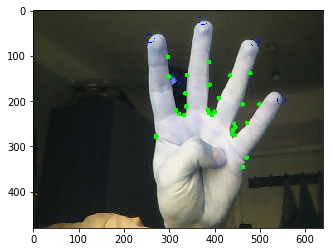

In [789]:
%%time
image3 = image2.copy()
imp_points = []
for num, i in enumerate(approx):
    count = 0 
    for j in max_hull:
        if np.linalg.norm(j-i) < delta and np.linalg.norm(j-i) > 0:
            count+=1   
    if count < 1:
        x, y = i.ravel()
        cv2.circle(image3, (x,y), 5 ,(0,255,0),-1)
        imp_points.append((x,y))
    
max_hull_top = np.array([i[0] for i in max_hull if i[0][1] < center[0][1]])
clustering = DBSCAN(eps=14, min_samples=1).fit(max_hull_top)
labels = clustering.labels_
means = []
for i in np.unique(labels):
    if i >= 0 and np.count_nonzero(labels==i) >= 2:
        array = []
        for num, j in enumerate(labels):
            if j == i:
                array.append(max_hull_top[num])
        if array != []:
            ax,ay = tuple(np.squeeze(np.mean(np.array(array),axis=0)))
            cv2.circle(image3,(int(ax),int(ay)) ,10, (0,0,255), 1)
            means.append((int(ax),int(ay)))
plt.imshow(image3)

In [162]:
leftmost = max_hull[max_hull[:,:,0].argmin()][0]
rightmost = max_hull[max_hull[:,:,0].argmax()][0]
topmost = max_hull[max_hull[:,:,1].argmin()][0]
bottommost = max_hull[max_hull[:,:,1].argmax()][0]

hdis = np.linalg.norm(leftmost-rightmost)
vdis = np.linalg.norm(topmost-bottommost)

hull = cv2.convexHull(cnt, returnPoints=False)
defects = cv2.convexityDefects(cnt, hull)

final = cv2.drawContours(image, max_hull_top, -1, (255, 0, 0), 5)
#final = cv2.drawContours(image, approx, -1, (0,255,0),5)
circles = [hdis//2,vdis//3, vdis//2.5, hdis//2.5]
for i in circles:
    cv2.circle(final,(cx, cy), int(i), (0,255,0),1)

In [411]:
means = [10, 30 , 60]
ax = 40
not any((mean in np.arange(ax-10,ax+10)) for mean in means)

False

In [494]:
def get_neighb(elem, narray):
    elem = elem.tolist()
    array = narray.copy()
    array.append(elem)
    array = sorted(array, key=lambda x:x[0])
    index = array.index(elem)
    
    if index > 0 and index != len(array)-1:
        return np.array([array[index-1], array[index+1]])
    else:
        return np.array(np.zeros((2,)))

def get_angle(p1, p2, p3):
    line1 = p2 - p1
    line2 = p3 - p1
    cosine = np.dot(line1, line2) / (np.linalg.norm(line1) * np.linalg.norm(line2))
    angle = np.arccos(cosine)
    print(angle * 180 / np.pi)
    return angle * 180 / np.pi

In [426]:
point = np.array([1,2])
angle(point, np.zeros(point.shape), np.zeros(point.shape))

1.2074182697257333e-06

In [630]:
def find_nearest(means, roots, image):
    means = sorted(means,key=lambda x:x[0])
    roots = sorted(roots,key=lambda x:x[0])
    means = np.array(means)
    roots = np.array(roots)
    for i in range(len(means)-1):
        angle = get_angle(roots[i],means[i],means[i+1])
        if angle > 10 and angle < 70:
            cv2.line(image, tuple(roots[i]), tuple(means[i+1]), (0,255,0),4)
            cv2.line(image, tuple(roots[i]), tuple(means[i]), (0,255,0),4)
    plt.imshow(image3)

35.293667535970634
36.63957038329857
41.366539417977926


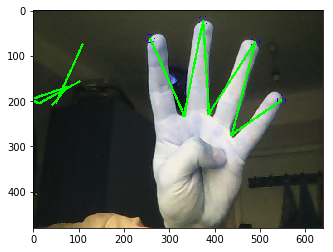

In [631]:
find_nearest(means,imp_points,image3)
#plt.imshow(image3)

In [665]:
approx

array([[251,  74],
       [251,  88],
       [252,  70],
       ...,
       [549, 189],
       [550, 198],
       [550, 192]], dtype=int32)

In [793]:
def find_root_points(approx):
    local = []
    for i in range(2,len(approx)-2):
        if approx[i][1] > approx[i+1][1] and approx[i][1] > approx[i-1][1] \
            and get_angle(approx[i],approx[i+1],approx[i-1])>15:
            print(approx[i-1],approx[i],approx[i+1],end='\n')
            local.append(approx[i])
    return local

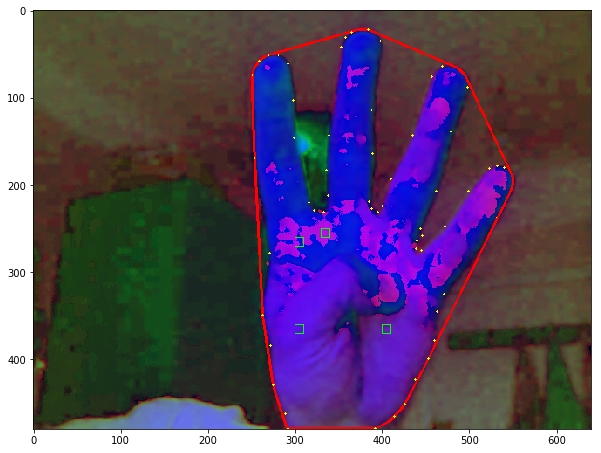

In [800]:
final2 = image2.copy()
final2 = cv2.drawContours(final, np.expand_dims(approx[:30],axis=1), -1,(255,255,0), 2)
plt.figure(figsize=(10,10))
plt.imshow(final2)

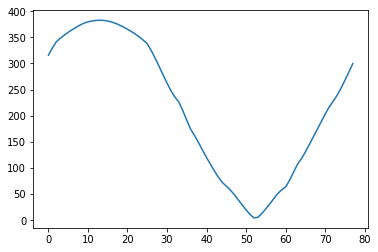

In [822]:
plt.plot(np.arange(len(filtered)),filtered)

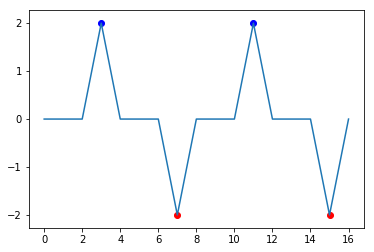

In [823]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

if __name__=="__main__":
    from matplotlib.pyplot import plot, scatter, show
    series = [0,0,0,2,0,0,0,-2,0,0,0,2,0,0,0,-2,0]
    maxtab, mintab = peakdet(series,.3)
    plot(series)
    scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
    scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
show()

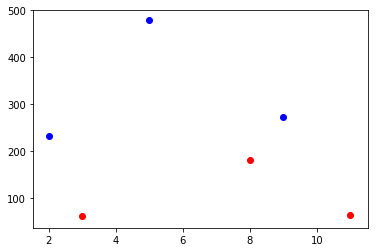

In [900]:
data = np.squeeze(approx,axis=1)
data = data[:,1]
maxtab, mintab = peakdet(data,.01)
scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')

In [901]:
for i in np.take(imp_points, min_tab[:,0],axis=0):
    print(tuple(i))

(298, 103)
(499, 207)
(479, 139)


In [902]:
data = np.array(np.squeeze(approx,axis=1))[:,1]
# data = np.arange(len(imp_points)-1)
_, indexes = peakdet(data,.2)
print(indexes)
if indexes.size>0:
    points = np.take(np.array(approx), indexes[:,0],axis=0)

[[  3  61]
 [  8 181]
 [ 11  64]]


In [961]:
dist = lambda i,j: np.linalg.norm(i-j)

In [962]:
npv = np.vectorize(dist)

In [968]:
distances = np.sqrt(np.sum(npv(np.squeeze(max_hull,axis=1), np.squeeze(max_hull,axis=1)[0])**2,axis=1))

In [986]:
%%time
for i in points:
    distances = np.sqrt(np.sum(npv(np.squeeze(max_hull,axis=1), i)**2,axis=1))
    if (distances > 10).all() == True:
        print(i)

[[292  61]]
[[523 181]]
[[469  64]]
CPU times: user 14.3 ms, sys: 424 µs, total: 14.7 ms
Wall time: 21.3 ms
